[nltk_data] Downloading package punkt to /Users/aqibullah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aqibullah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aqibullah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processed 0 lines.
Processed 10000 lines.
Training complete.
Percentage of positive reviews: 79.05333333333333
Percentage of negative reviews: 20.946666666666665
Average rating score: 4.215066666666667


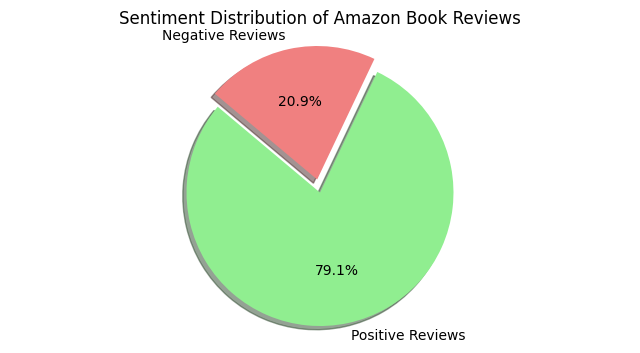

In [ ]:
import json
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
import joblib

# Download necessary NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Set of English stop words
stop_words = set(stopwords.words('english'))

def get_synonyms(word):
    """Retrieve synonyms for a given word using WordNet."""
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return synonyms

def preprocess_text(text):
    """Tokenize text, remove stopwords, and enrich with synonyms."""
    word_tokens = word_tokenize(text)
    filtered_sentence = []
    for w in word_tokens:
        if w.lower() not in stop_words:
            synonyms = get_synonyms(w)
            filtered_sentence.extend(synonyms)
    return " ".join(filtered_sentence)

def process_line(line):
    """Load JSON data, extract review text and sentiment based on rating."""
    json_data = json.loads(line)
    text = json_data.get('reviewText', '')
    overall = json_data.get('overall', 0)
    sentiment = 1 if overall > 3 else 0
    return preprocess_text(text), sentiment, overall

# Initialize the vectorizer and the SGDClassifier
vectorizer = HashingVectorizer(stop_words='english', n_features=2**18, alternate_sign=False)
classifier = SGDClassifier(loss='log_loss')  # Correct loss parameter

# Path to your JSON file
file_path = '/Users/aqibullah/Downloads/15000.json'

# Variables to store rating and sentiment counts
total_reviews = 0
positive_count = 0
negative_count = 0
total_rating = 0

# Process the file in chunks to manage memory usage
chunk_size = 1000
X_chunk, y_chunk = [], []

with open(file_path, 'r', encoding='utf-8') as file:
    for i, line in enumerate(file):
        X_line, y_line, overall = process_line(line)
        X_chunk.append(X_line)
        y_chunk.append(y_line)
        total_reviews += 1
        total_rating += overall
        if y_line == 1:
            positive_count += 1
        else:
            negative_count += 1
        
        if len(X_chunk) == chunk_size:
            X_vectorized = vectorizer.transform(X_chunk)
            classifier.partial_fit(X_vectorized, y_chunk, classes=[0, 1])
            X_chunk, y_chunk = [], []  # Clear the chunk

        if i % 10000 == 0:
            print(f"Processed {i} lines.")

# Make sure the last chunk is processed
if X_chunk:
    X_vectorized = vectorizer.transform(X_chunk)
    classifier.partial_fit(X_vectorized, y_chunk, classes=[0, 1])

# Save the classifier to disk
joblib.dump(classifier, 'sentiment_classifier.pkl')

# Calculate percentages and average rating
positive_percentage = (positive_count / total_reviews) * 100
negative_percentage = (negative_count / total_reviews) * 100
average_rating = total_rating / total_reviews

print("Training complete.")
print("Percentage of positive reviews:", positive_percentage)
print("Percentage of negative reviews:", negative_percentage)
print("Average rating score:", average_rating)

import matplotlib.pyplot as plt

# Assuming positive_percentage and negative_percentage are already calculated
labels = 'Positive Reviews', 'Negative Reviews'
sizes = [positive_percentage, negative_percentage]
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)  # explode 1st slice

plt.figure(figsize=(8, 4))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Sentiment Distribution of Amazon Book Reviews')
plt.show()